# SRC.Data_utils

In [3]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import calendar

# Add the parent directory to the Python path
from pathlib import Path

import numpy as np
import pandas as pd
import requests

from src.config import RAW_DATA_DIR
import zipfile


def fetch_raw_trip_data(year: int, month: int) -> Path:
    URL = f"https://s3.amazonaws.com/tripdata/JC-{year}{month:02}-citibike-tripdata.csv.zip"     
    response = requests.get(URL)

    if response.status_code == 200:
        zip_path = RAW_DATA_DIR / f"rides_{year}_{month:02}.zip"
        open(zip_path, "wb").write(response.content)
        # Extract the zip file
        #extracted_dir = RAW_DATA_DIR / "extracted_raw"
        #extracted_dir.mkdir(exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(RAW_DATA_DIR)
        
        # Find the CSV file in the extracted directory
        csv_files = list(RAW_DATA_DIR.glob("*.csv"))
        if not csv_files:
            raise Exception(f"No CSV file found in the extracted zip: {zip_path}")
        
        return csv_files[0]
    else:
        raise Exception(f"{URL} is not available")
    

def load_and_process_citi_data(years: list) -> pd.DataFrame:
    """
    Load and process CitiBike data for a specified year and list of months.

    Args:
        years (list): List of years to load data for.

    Returns:
        pd.DataFrame: Combined and processed ride data for the specified years.

    Raises:
        Exception: If no data could be loaded for the specified years.
    """

    months = list(range(1, 13))
    # List to store DataFrames for each month
    monthly_rides = []

    for year in years:
        for month in months:
            # Construct the file path
            file_path = RAW_DATA_DIR / f"JC-{year}{month:02}-citibike-tripdata.csv"

            # Load the data
            print(f"Loading data for {year}-{month:02}.")
            try:
                rides = pd.read_csv(file_path)
            # Append the processed DataFrame to the list
                monthly_rides.append(rides)
            except FileNotFoundError:
                continue

        # Combine all monthly data
        if not monthly_rides:
            raise Exception(
                f"No data could be loaded for the year {year} and specified months: {months}"
            )

        print("Combining all monthly data...")
        combined_rides = pd.concat(monthly_rides, ignore_index=True)
        print("Data loading and processing complete!")

        columns_to_drop = ['ride_id', 'end_station_name', 'rideable_type', 'ended_at', 'end_station_id','start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']  # Specify the columns to drop
        processed_rides = combined_rides.drop(columns=columns_to_drop)

        processed_rides.rename(columns={"started_at": "pickup_datetime", "start_station_name": "station_name", "start_station_id": "station_id"}, inplace=True)        

    return combined_rides, processed_rides

def transform_raw_data_into_ts_data(rides: pd.DataFrame) -> pd.DataFrame:
    """
    Transform raw ride data into time series format.

    Args:
        rides: DataFrame with pickup_datetime and location columns

    Returns:
        pd.DataFrame: Time series data with filled gaps
    """
    # Floor datetime to hour efficiently
    rides["pickup_hour"] = rides["started_at"].dt.floor("h")

    # Aggregate and fill gaps
    agg_rides = (
        rides.groupby(["pickup_hour", "start_station_id"])
        .size()
        .reset_index(name="rides")
    )
    return agg_rides 

def transform_ts_data_info_features_and_target_loop(df, feature_col="rides", window_size=12, step_size=1):
    """
    Transforms time series data for all unique location IDs into a tabular format.
    The first `window_size` rows are used as features, and the next row is the target.
    The process slides down by `step_size` rows at a time to create the next set of features and target.
    Feature columns are named based on their hour offsets relative to the target.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing time series data with 'pickup_hour' column.
        feature_col (str): The column name containing the values to use as features and target (default is "rides").
        window_size (int): The number of rows to use as features (default is 12).
        step_size (int): The number of rows to slide the window by (default is 1).

    Returns:
        tuple: (features DataFrame with pickup_hour, targets Series, complete DataFrame)
    """
    # Get all unique location IDs
    location_ids = df["start_station_id"].unique()
    # List to store transformed data for each location
    transformed_data = []

    # Loop through each location ID and transform the data
    for location_id in location_ids:
        try:
            # Filter the data for the given location ID
            location_data = df[df["start_station_id"] == location_id].reset_index(drop=True)

            # Extract the feature column and pickup_hour as NumPy arrays
            values = location_data[feature_col].values
            times = location_data["pickup_hour"].values

            # Ensure there are enough rows to create at least one window
            if len(values) <= window_size:
                raise ValueError("Not enough data to create even one window.")

            # Create the tabular data using a sliding window approach
            rows = []
            for i in range(0, len(values) - window_size, step_size):
                # The first `window_size` values are features, and the next value is the target
                features = values[i : i + window_size]
                target = values[i + window_size]
                # Get the corresponding target timestamp
                target_time = times[i + window_size]
                # Combine features, target, location_id, and timestamp
                row = np.append(features, [target, location_id, target_time])
                rows.append(row)

            # Convert the list of rows into a DataFrame
            feature_columns = [
                f"{feature_col}_t-{window_size - i}" for i in range(window_size)
            ]
            all_columns = feature_columns + [
                "target",
                "start_station_id",
                "pickup_hour",
            ]
            transformed_df = pd.DataFrame(rows, columns=all_columns)

            # Append the transformed data to the list
            transformed_data.append(transformed_df)

        except ValueError as e:
            print(f"Skipping location_id {location_id}: {str(e)}")

    # Combine all transformed data into a single DataFrame
    if not transformed_data:
        raise ValueError(
            "No data could be transformed. Check if input DataFrame is empty or window size is too large."
        )

    final_df = pd.concat(transformed_data, ignore_index=True)

    # Extract features (including pickup_hour), targets, and keep the complete DataFrame
    features = final_df[feature_columns + ["pickup_hour", "start_station_id"]]
    targets = final_df["target"]

    return features, targets

# Headers

In [2]:
#from src.data_utils import *
from src.config import *

# Data Processing

## Download Raw Data

In [4]:
for month in range(1, 13):
    try: 
        fetch_raw_trip_data(2024,month)
    except Exception as e:
        continue

## Load combined Data

In [4]:
years = [2021, 2023, 2022]
raw_df, df= load_and_process_citi_data(years)

Loading data for 2021-01.
Loading data for 2021-02.
Loading data for 2021-03.
Loading data for 2021-04.
Loading data for 2021-05.
Loading data for 2021-06.
Loading data for 2021-07.
Loading data for 2021-08.
Loading data for 2021-09.
Loading data for 2021-10.
Loading data for 2021-11.
Loading data for 2021-12.
Combining all monthly data...
Data loading and processing complete!
Loading data for 2023-01.
Loading data for 2023-02.
Loading data for 2023-03.
Loading data for 2023-04.
Loading data for 2023-05.
Loading data for 2023-06.
Loading data for 2023-07.
Loading data for 2023-08.
Loading data for 2023-09.
Loading data for 2023-10.
Loading data for 2023-11.
Loading data for 2023-12.
Combining all monthly data...
Data loading and processing complete!
Loading data for 2022-01.
Loading data for 2022-02.
Loading data for 2022-03.
Loading data for 2022-04.
Loading data for 2022-05.
Loading data for 2022-06.
Loading data for 2022-07.
Loading data for 2022-08.
Loading data for 2022-09.
Loadin

In [5]:
columns_to_drop = ['ride_id', 'end_station_name', 'rideable_type', 'ended_at', 'end_station_id','start_lat', 'start_lng', 'end_lat', 'end_lng', 'member_casual']  # Specify the columns to drop
raw_df = raw_df.drop(columns=columns_to_drop)

raw_df.rename(columns={"started_at": "pickup_datetime", "start_station_name": "station_name", "start_station_id": "station_id"}, inplace=True)
raw_df.tail()

,pickup_datetime,station_name,station_id
2354887,2022-12-06 15:43:38,Dey St,JC065
2354888,2022-12-08 08:17:51,9 St HBLR - Jackson St & 8 St,HB305
2354889,2022-12-23 14:10:07,Mama Johnson Field - 4 St & Jackson St,HB404
2354890,2022-12-02 04:43:25,Mama Johnson Field - 4 St & Jackson St,HB404
2354891,2022-12-30 14:50:17,14 St Ferry - 14 St & Shipyard Ln,HB202


In [6]:
raw_df

,pickup_datetime,station_name,station_id
0,2021-07-15 19:27:25,Journal Square,JC103
1,2021-07-22 06:41:54,Journal Square,JC103
2,2021-07-19 06:36:13,Brunswick & 6th,JC081
3,2021-07-08 06:33:45,Brunswick & 6th,JC081
4,2021-07-21 07:33:49,14 St Ferry - 14 St & Shipyard Ln,HB202
...,...,...,...
2354887,2022-12-06 15:43:38,Dey St,JC065
2354888,2022-12-08 08:17:51,9 St HBLR - Jackson St & 8 St,HB305
2354889,2022-12-23 14:10:07,Mama Johnson Field - 4 St & Jackson St,HB404
2354890,2022-12-02 04:43:25,Mama Johnson Field - 4 St & Jackson St,HB404


## New Process

## Location ID: HB101, JC115, HB102

In [7]:
raw_df["pickup_datetime"] = pd.to_datetime(raw_df["pickup_datetime"])
raw_df["pickup_hour"] = raw_df["pickup_datetime"].dt.floor('h')
raw_df.tail()

,pickup_datetime,station_name,station_id,pickup_hour
2354887,2022-12-06 15:43:38,Dey St,JC065,2022-12-06 15:00:00
2354888,2022-12-08 08:17:51,9 St HBLR - Jackson St & 8 St,HB305,2022-12-08 08:00:00
2354889,2022-12-23 14:10:07,Mama Johnson Field - 4 St & Jackson St,HB404,2022-12-23 14:00:00
2354890,2022-12-02 04:43:25,Mama Johnson Field - 4 St & Jackson St,HB404,2022-12-02 04:00:00
2354891,2022-12-30 14:50:17,14 St Ferry - 14 St & Shipyard Ln,HB202,2022-12-30 14:00:00


In [8]:
agg_rides = raw_df.groupby(["pickup_hour", "station_id"]).size().reset_index()
agg_rides.rename(columns={0: "rides"}, inplace=True)
agg_rides.tail()

,pickup_hour,station_id,rides
846010,2023-12-31 23:00:00,JC104,1
846011,2023-12-31 23:00:00,JC108,2
846012,2023-12-31 23:00:00,JC109,1
846013,2023-12-31 23:00:00,JC115,4
846014,2023-12-31 23:00:00,JC116,1


In [9]:
filtered_df = agg_rides[agg_rides["rides"] > 30]
filtered_df

,pickup_hour,station_id,rides
2892,2021-07-04 20:00:00,JC106,31
3023,2021-07-05 00:00:00,HB103,34
12299,2021-07-15 18:00:00,HB103,32
16873,2021-07-20 18:00:00,HB103,34
16932,2021-07-20 19:00:00,HB103,32
...,...,...,...
811533,2023-11-20 18:00:00,JC115,32
824092,2023-12-05 17:00:00,HB102,32
824155,2023-12-05 17:00:00,JC115,31
825119,2023-12-06 18:00:00,HB102,33


## Process Data

In [10]:
def fill_missing_rides_full_range(df, hour_col, location_col, rides_col):
    """
    Fills in missing rides for all hours in the range and all unique locations.

    Parameters:
    - df: DataFrame with columns [hour_col, location_col, rides_col]
    - hour_col: Name of the column containing hourly timestamps
    - location_col: Name of the column containing location IDs
    - rides_col: Name of the column containing ride counts

    Returns:
    - DataFrame with missing hours and locations filled in with 0 rides
    """
    # Ensure the hour column is in datetime format
    df[hour_col] = pd.to_datetime(df[hour_col])

    # Get the full range of hours (from min to max) with hourly frequency
    full_hours = pd.date_range(
        start=df[hour_col].min(),
        end=df[hour_col].max(),
        freq="h"
    )

    # Get all unique location IDs
    all_locations = df[location_col].unique()

    # Create a DataFrame with all combinations of hours and locations
    full_combinations = pd.DataFrame(
        [(hour, location) for hour in full_hours for location in all_locations],
        columns=[hour_col, location_col]
    )

    # Merge the original DataFrame with the full combinations DataFrame
    merged_df = pd.merge(full_combinations, df, on=[hour_col, location_col], how='left')

    # Fill missing rides with 0
    merged_df[rides_col] = merged_df[rides_col].fillna(0).astype(int)

    return merged_df

In [11]:
hour_col = "pickup_hour"
location_col = "station_id"
rides_col = "rides"
agg_data_filled = fill_missing_rides_full_range(agg_rides, hour_col, location_col, rides_col).sort_values(["station_id", "pickup_hour"]).reset_index(drop=True)

In [16]:
df = agg_data_filled[agg_data_filled["rides"]>30]

In [17]:
unique_values = df["station_id"].unique()
unique_values

array(['HB101', 'HB102', 'HB103', 'HB105', 'HB201', 'JC005', 'JC006',
       'JC106', 'JC115'], dtype=object)

In [99]:
def aggregate_rides(df, interval, hour_col, rides_col):
    """
    Aggregates the rides column into specified time intervals.

    Parameters:
    - df: DataFrame with hourly data
    - interval: Resampling interval (e.g., '2H', '4H', '6H')
    - hour_col: Name of the column containing hourly timestamps
    - rides_col: Name of the column containing ride counts

    Returns:
    - Aggregated DataFrame
    """
    # Set the hour column as the index
    df = df.set_index(hour_col)

    # Resample and aggregate rides
    aggregated_df = df.groupby("station_id").resample(interval)[rides_col].sum().reset_index()

    return aggregated_df

In [100]:
from datetime import datetime

# Define the particular date
particular_date_2h = datetime(2021, 11, 6)
particular_date_4h = datetime(2021, 9, 11)
particular_date_6h = datetime(2021, 7, 17)

# Filter the data from the particular date
agg_data_filled_2h = agg_data_filled[agg_data_filled["pickup_hour"] >= particular_date_2h]
agg_data_filled_4h = agg_data_filled[agg_data_filled["pickup_hour"] >= particular_date_4h]
agg_data_filled_6h = agg_data_filled[agg_data_filled["pickup_hour"] >= particular_date_6h]

In [101]:
# Aggregate rides into 2-hour, 4-hour, and 6-hour intervals
agg_data_2h = aggregate_rides(agg_data_filled_2h, '2h', hour_col, rides_col)
agg_data_4h = aggregate_rides(agg_data_filled_4h, '4h', hour_col, rides_col)
agg_data_6h = aggregate_rides(agg_data_filled_6h, '6h', hour_col, rides_col)

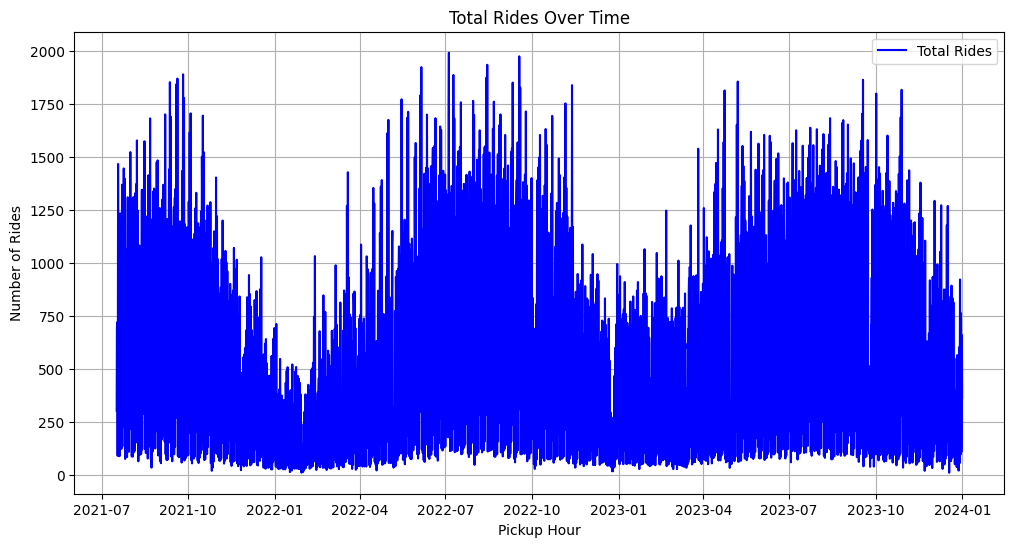

In [102]:
import matplotlib.pyplot as plt

# Group data by station_id and sum rides for each hour
agg_data_filled_grouped = agg_data_6h.groupby("pickup_hour")["rides"].sum()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(agg_data_filled_grouped.index, agg_data_filled_grouped.values, label="Total Rides", color="blue")

# Add labels and title
plt.xlabel("Pickup Hour")
plt.ylabel("Number of Rides")
plt.title("Total Rides Over Time")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [105]:
agg_data_6h.to_csv(
    os.path.join(
        PROCESSED_DATA_DIR,
        "processed_data_6h.csv",
    ),
    index=False,
)